In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

C:\Users\Mahmoud Kholief\AppData\Roaming\Python\Python37\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
# construct the argument parser and parse the arguments

# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", default="our_DATA/train and val",
#     help="path to input dataset")
# ap.add_argument("-p", "--plot", type=str, default="plot.png",
#     help="path to output loss/accuracy plot")
# ap.add_argument("-m", "--model", type=str, default="covid19.model",
#     help="path to output loss/accuracy plot")
# args = vars(ap.parse_args())

arguments = {'dataset' : 'our_DATA/train and val','model' : 'covid19.model', 'plot' : 'plot.png' }

In [3]:
# initialize the initial learning rate, number of epochs to train for,and batch size
INIT_LR = 1e-3
EPOCHS = 10
BS = 8

In [4]:
# grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images
imagePaths = list(paths.list_images(arguments["dataset"]))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # print(label)

    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

In [5]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data)
# data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [6]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.2, stratify=labels, random_state=42)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")


In [7]:
# load the inception network, ensuring the head FC layer sets are left off
baseModel = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [8]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [10]:
# load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [11]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

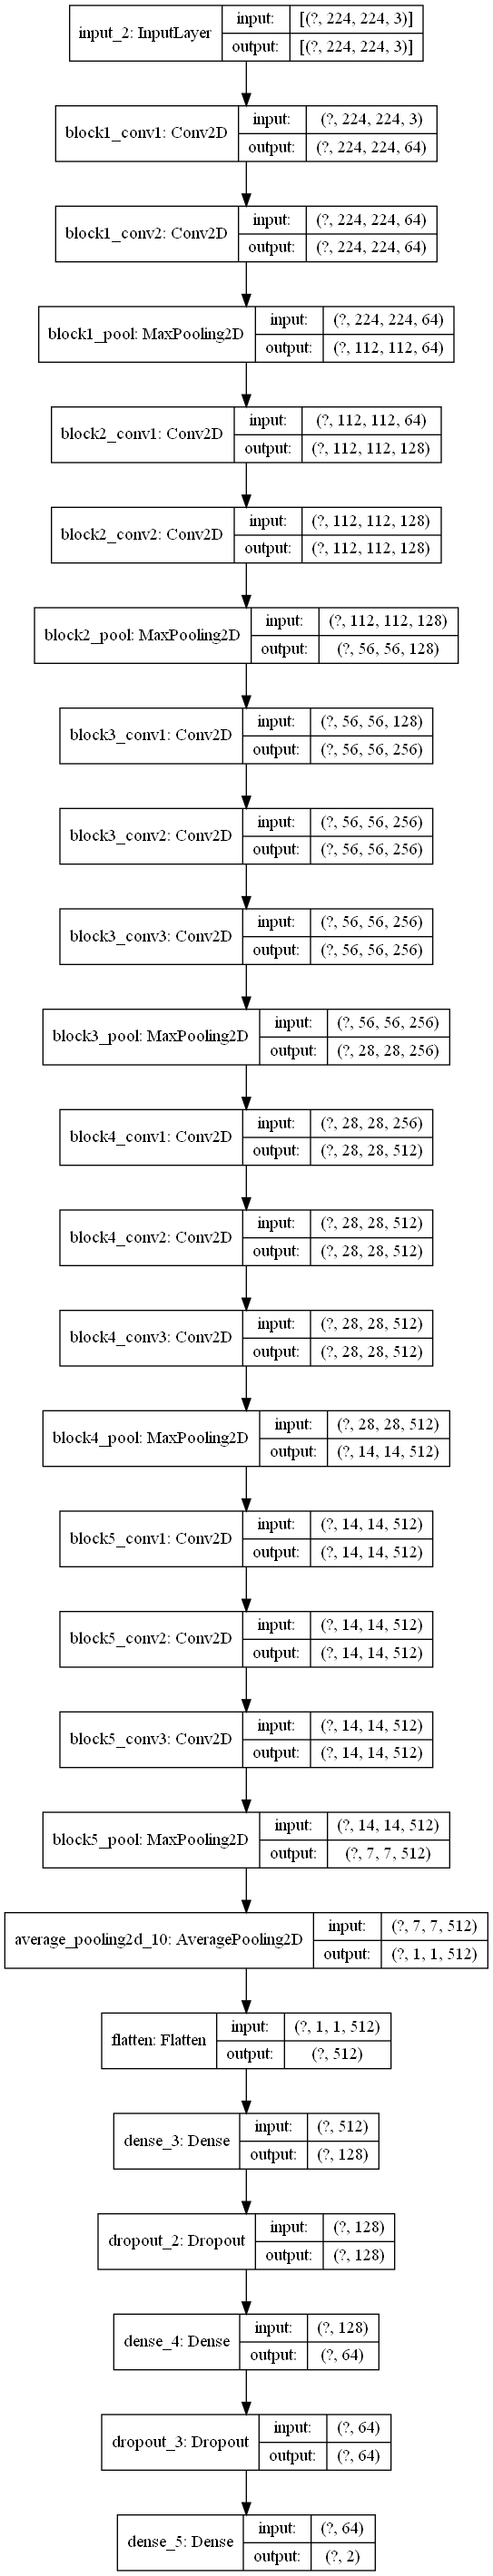

In [12]:
plot_model(model, show_shapes=True)

In [13]:
# compile our model
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=INIT_LR), metrics=["accuracy"])

In [14]:
# train the head of the network
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/10
32/32 [==============================] - 45s 1s/step - loss: 2.1110 - accuracy: 0.7092 - val_loss: 0.0706 - val_accuracy: 0.9846
Epoch 2/10
32/32 [==============================] - 31s 957ms/step - loss: 0.8717 - accuracy: 0.8446 - val_loss: 6.9614e-05 - val_accuracy: 1.0000
Epoch 3/10
32/32 [==============================] - 30s 950ms/step - loss: 0.3100 - accuracy: 0.9243 - val_loss: 5.2133e-04 - val_accuracy: 1.0000
Epoch 4/10
32/32 [==============================] - 30s 950ms/step - loss: 0.3179 - accuracy: 0.9044 - val_loss: 1.7141e-04 - val_accuracy: 1.0000
Epoch 5/10
32/32 [==============================] - 30s 950ms/step - loss: 0.1525 - accuracy: 0.9641 - val_loss: 3.8605e-05 - val_accuracy: 1.0000
Epoch 6/10
32/32 [==============================] - 30s 947ms/step - loss: 0.1208 - accuracy: 0.9681 - val_loss: 1.2970e-05 - val_accuracy: 1.0000
Epoch 7/10
32/32 [==============================] - 30s 950ms/step - loss: 0.1415 - accuracy: 0.9562 - val_loss: 1.0359e-05 -

In [15]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predictions = np.argmax(predictions, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predictions,
    target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        32
    Positive       1.00      1.00      1.00        33

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65



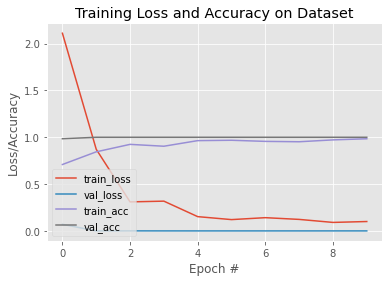

In [16]:
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(arguments["plot"])

In [17]:
# serialize the model to disk
print("saving model...")
model.save(arguments["model"], save_format="h5")

saving model...


In [18]:
saved_model_path = "lallo.h5" 
model.save(saved_model_path)

In [19]:
import pickle
f = open("simple_nn_lb.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()